<a href="https://colab.research.google.com/github/Tudou77/DS340W/blob/main/implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## load data

In [4]:
import requests
from io import StringIO
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error,precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import accuracy_score

url="https://drive.google.com/file/d/1Wf3U7CjPvPDkRObF0R9qM08pMNJRf9CJ/view?usp=sharing"


#target dataset


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url2 = requests.get(dwn_url).text
csv_raw = StringIO(url2)
shots = pd.read_csv(csv_raw)

##feature engineering


In [6]:
shots.columns = shots.columns.str.lower()
shots.dtypes

game_id                         int64
matchup                        object
location                       object
w                              object
final_margin                    int64
shot_number                     int64
period                          int64
game_clock                     object
shot_clock                    float64
dribbles                        int64
touch_time                    float64
shot_dist                     float64
pts_type                        int64
shot_result                    object
closest_defender               object
closest_defender_player_id      int64
close_def_dist                float64
fgm                             int64
pts                             int64
player_name                    object
player_id                       int64
dtype: object

In [7]:
# Convert game clock to seconds
shots['game_clock'] = shots['game_clock'].apply(
    lambda x: 60*int(x.split(':')[0]) + int(x.split(':')[1])
)

# Replacing abnormal values with NaNs
shots.loc[shots['touch_time'] < 0, 'touch_time'] = np.nan

# Converting type of shot (2 or 3 points) to categorical
shots['pts_type'] = (shots['pts_type'] == 3) * 1

# Converting location
shots['location'] = (shots['location'] == 'H') * 1

# Renaming columns
shots = shots.rename(columns = {
    'fgm':'hit',
    'pts_type':'3pts_shot',
    'location':'home_match'
})

# Dropping informative columns (not useful to modelling) as well as 
# future variables which won't be available at predicting time
shots = shots.drop(columns = [
    'game_id',
    'matchup',
    'w',
    'final_margin',
    'closest_defender_player_id',
    'player_id',
    'shot_result',
    'closest_defender',
    'player_name',
    'pts'
])




In [8]:
shots_scaled = shots.copy()
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# Stardardization
shots_scaled[['shot_clock']] = preprocessing.StandardScaler().fit_transform(shots[['shot_clock']].values)

# Robust scaling
skewed_cols = ['shot_number', 'dribbles', 'touch_time', 'close_def_dist']
shots_scaled[skewed_cols] = preprocessing.RobustScaler().fit_transform(shots[skewed_cols].values)
    
# Min max transformation
min_max_cols = ['period', 'game_clock', 'shot_dist']
shots_scaled[min_max_cols] = preprocessing.MinMaxScaler().fit_transform(shots[min_max_cols].values)

# Filling NaNs with mean
shots_scaled['shot_clock'] = shots_scaled['shot_clock'].fillna(shots_scaled['shot_clock'].mean())
shots_scaled['touch_time'] = shots_scaled['touch_time'].fillna(shots_scaled['touch_time'].median())
shots['shot_clock'] = shots['shot_clock'].fillna(shots['shot_clock'].mean())
shots['touch_time'] = shots['touch_time'].fillna(shots['touch_time'].median())

##PCA

In [9]:
# Fitting PCA and showing PVE
from sklearn.decomposition import PCA
pca = PCA(random_state=42).fit(shots_scaled.drop('hit', axis=1).values)
pve = pca.explained_variance_ratio_

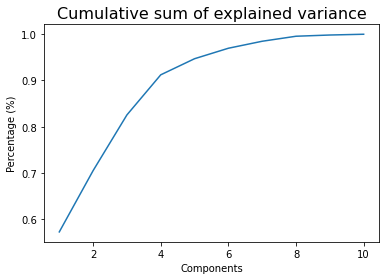

In [10]:
plt.plot(range(1, len(pve) + 1), pve.cumsum())
plt.title('Cumulative sum of explained variance', fontsize=16)
plt.xlabel('Components')
plt.ylabel('Percentage (%)')
plt.show()

##split dataset

In [11]:
X = shots.drop('hit', axis = 1).values
y = shots['hit'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Splitting scaled and transformed by PCA dataset
X_scaled = pca.transform(shots_scaled.drop('hit', axis = 1).values)[:,:4]
x_train_scaled, x_test_scaled, _, _ = train_test_split(X_scaled, y, test_size = 0.2, random_state=42)

##random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
randomforest_model = RandomForestClassifier()
randomforest_model.fit(x_train_scaled, y_train)

predictions = randomforest_model.predict(x_test_scaled)

actuals = y_test

print(confusion_matrix(actuals, predictions))
print("precision_score:",precision_score(actuals, predictions))
print("accuracy_score:", accuracy_score(actuals, predictions))

[[9669 4327]
 [7183 4435]]
precision_score: 0.506162976489386
accuracy_score: 0.5506363707347545


##Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()
LR_model.fit(x_train_scaled, y_train)

predictions = LR_model.predict(x_test_scaled)

actuals = y_test

print(confusion_matrix(actuals, predictions))
print("precision_score:",precision_score(actuals, predictions))
print("accuracy_score:", accuracy_score(actuals, predictions))

[[11966  2030]
 [ 9047  2571]]
precision_score: 0.5587915670506411
accuracy_score: 0.5675411884125868


##Naive Bayes


In [14]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

mnb=GaussianNB()
mnb_model = mnb.fit(x_train_scaled, y_train)
predictions = mnb_model.predict(x_test_scaled)

actuals = y_test

print(confusion_matrix(actuals, predictions))
print("precision_score:",precision_score(actuals, predictions))
print("accuracy_score:", accuracy_score(actuals, predictions))

[[11319  2677]
 [ 8544  3074]]
precision_score: 0.5345157363936707
accuracy_score: 0.5619192629030999


##Nerual Network

In [15]:
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier()
mlp_model = mlp.fit(x_train_scaled, y_train)
predictions = mlp_model.predict(x_test_scaled)

actuals = y_test

print(confusion_matrix(actuals, predictions))
print("precision_score:",precision_score(actuals, predictions))
print("accuracy_score:", accuracy_score(actuals, predictions))


[[11294  2702]
 [ 8053  3565]]
precision_score: 0.568852720599968
accuracy_score: 0.5801124385101898


##XGBOOST

In [16]:
xgb_model = XGBClassifier().fit(x_train_scaled, y_train)

predictions = xgb_model.predict(x_test_scaled)

actuals = y_test

print(confusion_matrix(actuals, predictions))
print(precision_score(actuals, predictions) )




'''
parameters_for_testing = {
    'min_child_weight':[0.0001,0.001,0.01,0.1],
    'learning_rate':[0.00001,0.0001,0.001],
    'n_estimators':[1,2,3,5,10],
    'max_depth':[2,3,4,5]
}
'''
parameters_for_testing = {
    'min_child_weight':[0.0001,0.001,0.01,0.1],
    'learning_rate':[0.0001,0.001],
    'n_estimators':[1,3,5,10],
    'max_depth':[3,4]
}
# Parameter tuning using 7 features
xgb_model = XGBClassifier()

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, scoring='precision')
gsearch1.fit(x_train,y_train)

print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

[[11515  2481]
 [ 8184  3434]]
0.5805579036348267
best params
{'learning_rate': 0.0001, 'max_depth': 3, 'min_child_weight': 0.0001, 'n_estimators': 1}
best score
0.6802144971020985


##SVM

In [17]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
svm=SVC()
svm_model = svm.fit(x_train_scaled, y_train)
predictions = svm_model.predict(x_test_scaled)

actuals = y_test

print(confusion_matrix(actuals, predictions))
print("precision_score:",precision_score(actuals, predictions))
print("accuracy_score:", accuracy_score(actuals, predictions))